# Testing against the ISPRS Reference Dataset

Prior to its <a target="_blank" href="http://dx.doi.org/10.1016/j.isprsjprs.2012.12.002">publication</a>, SMRF was tested against the <a target="_blank" href="http://www.itc.nl/isprswgIII-3/filtertest/StartPage.htm">ISPRS Dataset for Extracting DEMs from Point Clouds</a>.  The <a target = "_blank" href="http://www.itc.nl/isprswgIII-3/filtertest/Reference.zip">reference dataset</a> includes x,y,z, and identified ground points using both automatic and manual classification.  The [original algorithm](https://github.com/thomaspingel/smrf-matlab) developed in Matlab, and so performance metrics given here differ slightly from that implementation, with a slightly better mean performance, but slightly worse median performance than <a target="_blank" href="https://github.com/thomaspingel/smrf-matlab">the Matlab implementation</a>.

In [2]:
import smrf
from laspy.file import File

import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import glob

Type I Error:   2.005663048607834
Type II Error:  4.124985950320332
Total Error:    3.0910032809532084
Cohen's Kappa:  93.81095763752776


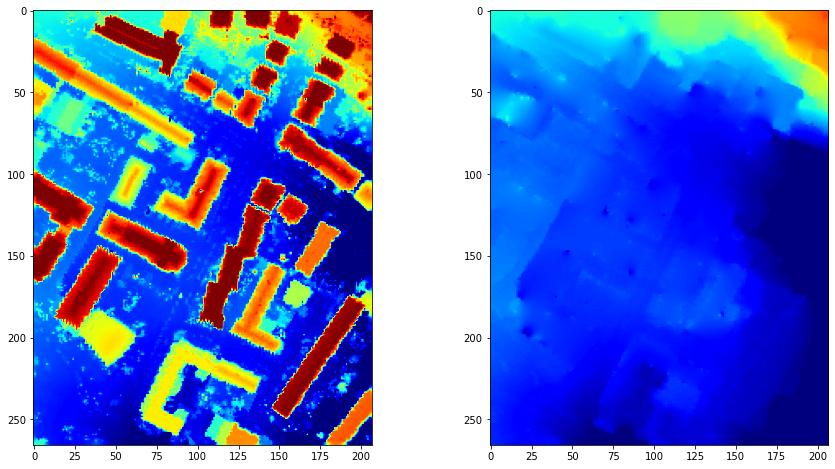

In [3]:
fn = 'data/samp12.txt'
df = pd.read_csv(fn,header=None,names=['x','y','z','g'],delimiter='\t')

cellsize = 1

# Create a DSM for reference to processed set:
Z, T = smrf.create_dem(df.x,df.y,df.z,cellsize,bin_type='max',inpaint=True)

# Best overall parameters for all samples:
windows = 18
slope_threshold = .15
elevation_threshold = .5
elevation_scaler = 1.25
Zsmrf, Tsmrf, obj_cells, obj_points = smrf.smrf(df.x,df.y,df.z,cellsize,windows,slope_threshold,
                                                  elevation_threshold,elevation_scaler)

total_error = 1 - np.sum(obj_points == df.g) / len(df)
type_I_error = np.sum((df.g==0) & (obj_points==1)) / np.sum(df.g==1)
type_II_error = np.sum((df.g==1) & (obj_points==0)) / np.sum(df.g==0)
kappa_score = cohen_kappa_score(df.g,obj_points)

print('Type I Error:  ',100 * type_I_error)
print('Type II Error: ',100 * type_II_error)
print('Total Error:   ',100 * total_error)
print('Cohen\'s Kappa: ',100 * kappa_score)

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(Z,cmap='jet',vmin=np.percentile(Z,5),vmax=np.percentile(Z,95))
plt.subplot(122)
plt.imshow(Zsmrf,cmap='jet',vmin=np.percentile(Z,5),vmax=np.percentile(Z,95))
plt.show()

# A Complete Test Against the ISPRS Dataset

In [4]:
optimized = pd.read_csv('data/isprs_smrf_settings.txt',index_col='filename')
optimized.head(15)

,slope_threshold,windows,elevation_threshold,elevation_scaler
filename,,,,
samp11.txt,0.20,16,0.45,1.20
samp12.txt,0.18,12,0.30,0.95
samp21.txt,0.12,20,0.60,0.00
samp22.txt,0.16,18,0.35,1.30
samp23.txt,0.27,13,0.50,0.90
samp24.txt,0.16,8,0.20,2.05
samp31.txt,0.08,15,0.25,1.50
samp41.txt,0.22,16,1.10,0.00
samp42.txt,0.06,49,1.05,0.00


In [5]:
single = {}
single['slope_threshold'] = .15
single['windows'] = 18
single['elevation_threshold'] = .5
single['elevation_scaler'] = 1.25

In [6]:
cellsize = 1

col_names = ['filename','t1','t2','te','k','te_single','k_single']
results = pd.DataFrame()

for index,row in optimized.iterrows():
    print(index)
    df = pd.read_csv('data/' + index,header=None,names=['x','y','z','g'],delimiter='\t')
    
    # Optimized
    Zsmrf, Tsmrf, obj_cells, obj_points = smrf.smrf(df.x,df.y,df.z,cellsize,int(row['windows']),row['slope_threshold'],
                                                  row['elevation_threshold'],row['elevation_scaler'],
                                                   low_filter_slope=500,low_outlier_fill=False)
    te = 1 - np.sum(obj_points == df.g) / len(df)
    t1 = np.sum((df.g==0) & (obj_points==1)) / np.sum(df.g==1)
    t2 = np.sum((df.g==1) & (obj_points==0)) / np.sum(df.g==0)
    k = cohen_kappa_score(df.g,obj_points)
    
    # Single
    Zsmrf, Tsmrf, obj_cells, obj_points = smrf.smrf(df.x,df.y,df.z,cellsize,int(single['windows']),
                                                    single['slope_threshold'],single['elevation_threshold'],
                                                    single['elevation_scaler'],low_filter_slope=500,
                                                    low_outlier_fill=False)
    te2 = 1 - np.sum(obj_points == df.g) / len(df)
    k2 = cohen_kappa_score(df.g,obj_points)

    # Record results
    results = results.append([[index,t1,t2,te,k,te2,k2]],ignore_index=True)
    
results.columns = col_names

results.describe()

samp11.txt
samp12.txt
samp21.txt
samp22.txt
samp23.txt
samp24.txt
samp31.txt
samp41.txt
samp42.txt
samp51.txt
samp52.txt
samp53.txt
samp54.txt
samp61.txt
samp71.txt


,t1,t2,te,k,te_single,k_single
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.081590,0.033391,0.035110,0.887818,0.044727,0.853680
std,0.088227,0.027153,0.029957,0.085087,0.028349,0.120339
min,0.001066,0.003899,0.008813,0.682208,0.016999,0.479213
25%,0.017885,0.014697,0.017226,0.840959,0.027272,0.798716
50%,0.051992,0.023862,0.024056,0.917272,0.035253,0.897027
75%,0.124681,0.046360,0.037718,0.950747,0.049938,0.926040
max,0.272858,0.091931,0.115662,0.976269,0.113258,0.947228
